# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres_freeamt import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(20)

,time,close0,itvl,datetime,close1,spread,zscore
128320,1703817659999,0.000474,1m,2023-12-29 02:40:59.999,0.000514,-0.000041,0.004392
128321,1703817719999,0.000474,1m,2023-12-29 02:41:59.999,0.000515,-0.000041,-0.056085
128322,1703817779999,0.000474,1m,2023-12-29 02:42:59.999,0.000517,-0.000044,-0.372399
128323,1703817839999,0.000474,1m,2023-12-29 02:43:59.999,0.000517,-0.000044,-0.374169
128324,1703817899999,0.000474,1m,2023-12-29 02:44:59.999,0.000517,-0.000044,-0.376171
128325,1703817959999,0.000473,1m,2023-12-29 02:45:59.999,0.000517,-0.000044,-0.441476
128326,1703818019999,0.000473,1m,2023-12-29 02:46:59.999,0.000517,-0.000044,-0.425762
128327,1703818079999,0.000473,1m,2023-12-29 02:47:59.999,0.000517,-0.000044,-0.482393
128328,1703818139999,0.000473,1m,2023-12-29 02:48:59.999,0.000517,-0.000044,-0.511045
128329,1703818199999,0.000473,1m,2023-12-29 02:49:59.999,0.000517,-0.000044,-0.513895


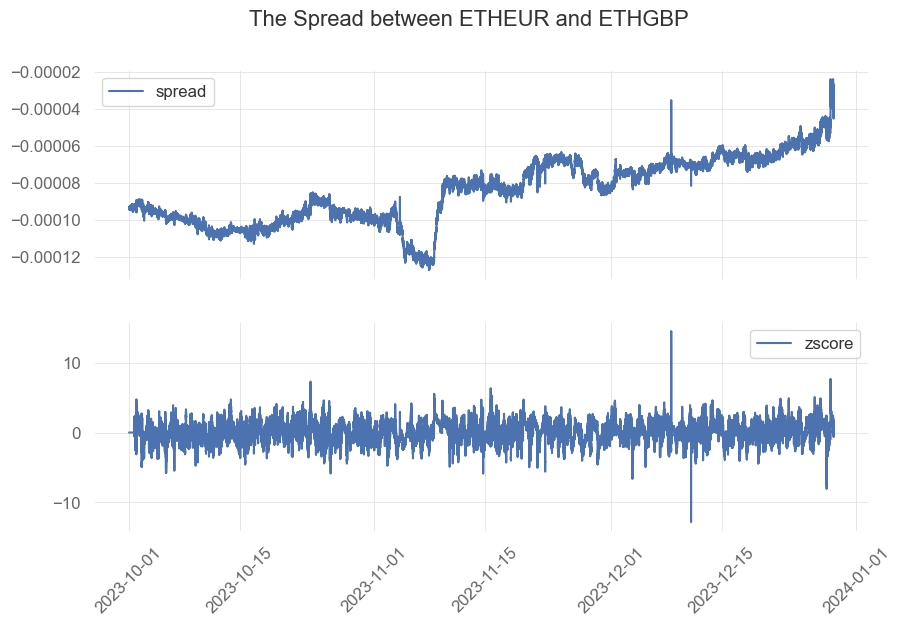

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 44640


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
env.action_space.sample()

array([-0.37844626])

Tensorboard

## Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres_freeamt/A2C_1
Deleted: logs/restrict_thres_freeamt/PPO_1


In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [9]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [10]:
'''
DQN doesn't support Box Actions
'''

# model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
# model_dqn.save(f"{folder_path}/dqn_pairtrading")

"\nDQN doesn't support Box Actions\n"

## Create the Custom Test Env

In [11]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
# test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [12]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 41040


## Test Env with Trained Model

In [13]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 12/41040 [00:00<06:22, 107.15it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 1.0, reward:100.0, networth: 1.0


 10%|█         | 4114/41040 [00:50<08:07, 75.70it/s]

signal: {'position': 2, 'zone': 2, 'zscore': array([-0.1520439])}, action: 0.8956303596496582, reward:0.018, networth: 1.0035


 20%|██        | 8225/41040 [01:32<05:45, 94.90it/s] 

signal: {'position': 2, 'zone': 2, 'zscore': array([0.08627466])}, action: -0.21312135457992554, reward:-0.022, networth: 0.995


 30%|███       | 12330/41040 [02:13<04:54, 97.55it/s] 

signal: {'position': 0, 'zone': 1, 'zscore': array([1.04332489])}, action: -1.0, reward:100.197, networth: 1.0246


 40%|████      | 16434/41040 [02:54<04:15, 96.46it/s] 

signal: {'position': 0, 'zone': 3, 'zscore': array([-0.53540716])}, action: 0.5742040276527405, reward:-0.086, networth: 1.022


 50%|█████     | 20534/41040 [03:34<03:26, 99.53it/s] 

signal: {'position': 0, 'zone': 1, 'zscore': array([1.02932751])}, action: -1.0, reward:100.09, networth: 1.0229


 60%|██████    | 24640/41040 [04:15<02:41, 101.82it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.38472686])}, action: 0.35061508417129517, reward:0.004, networth: 1.0521


 70%|███████   | 28742/41040 [04:55<02:01, 101.01it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.68014561])}, action: -1.0, reward:99.997, networth: 1.0773


 80%|████████  | 32845/41040 [05:37<01:23, 98.30it/s] 

signal: {'position': 2, 'zone': 1, 'zscore': array([0.60771416])}, action: -0.7792591452598572, reward:-0.012, networth: 1.0509


 90%|█████████ | 36947/41040 [06:17<00:41, 97.64it/s] 

signal: {'position': 2, 'zone': 4, 'zscore': array([-2.30703784])}, action: 1.0, reward:100.0, networth: 1.069


100%|██████████| 41040/41040 [06:58<00:00, 98.13it/s] 

Finished
networth: 1.0535177404510252


In [14]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 12/41040 [00:00<05:55, 115.35it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 1.0, reward:100.0, networth: 1.0


 10%|█         | 4118/41040 [00:43<06:19, 97.36it/s] 

signal: {'position': 0, 'zone': 2, 'zscore': array([-0.1520439])}, action: -1.0, reward:0.004, networth: 0.99


 20%|██        | 8233/41040 [01:20<04:44, 115.41it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.08627466])}, action: -1.0, reward:-0.046, networth: 0.985


 30%|███       | 12337/41040 [01:56<03:56, 121.35it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([1.04332489])}, action: -1.0, reward:100.17, networth: 1.0338


 40%|████      | 16442/41040 [02:30<03:27, 118.60it/s]

signal: {'position': 0, 'zone': 3, 'zscore': array([-0.53540716])}, action: -0.7495362758636475, reward:-0.233, networth: 1.0376


 50%|█████     | 20542/41040 [03:04<02:52, 118.78it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([1.02932751])}, action: -1.0, reward:100.094, networth: 1.0641


 60%|██████    | 24642/41040 [03:40<02:40, 102.01it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.38472686])}, action: -1.0, reward:0.004, networth: 1.0572


 70%|███████   | 28746/41040 [04:20<01:56, 105.68it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.68014561])}, action: -1.0, reward:99.996, networth: 1.0643


 80%|████████  | 32848/41040 [04:59<01:30, 90.05it/s] 

signal: {'position': 0, 'zone': 1, 'zscore': array([0.60771416])}, action: -1.0, reward:99.984, networth: 1.0762


 90%|█████████ | 36947/41040 [05:39<00:42, 96.40it/s] 

signal: {'position': 2, 'zone': 4, 'zscore': array([-2.30703784])}, action: 1.0, reward:100.0, networth: 1.0623


100%|██████████| 41040/41040 [06:19<00:00, 108.23it/s]

Finished
networth: 1.0427077093358819


In [15]:
# try:
#     os.remove(f"{folder_path}/networth_dqn.csv")
# except OSError:
#     pass

# obs, _ = test_env_dqn.reset()

# for i in trange(max_test_len):
#     action, _states = model_dqn.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_dqn.render()

# test_env_dqn.close()

## Also run randomly generated actions

In [16]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 0/41040 [00:00<?, ?it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: -0.9216981132011999, reward:0.0, networth: 1.0


 10%|█         | 4117/41040 [00:41<04:05, 150.69it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([-0.1520439])}, action: -0.030958935356179218, reward:0.077, networth: 0.9792


 20%|██        | 8231/41040 [01:08<03:59, 136.74it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.08627466])}, action: 0.6964182305090496, reward:-0.006, networth: 0.9728


 30%|███       | 12326/41040 [01:35<03:15, 147.12it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([1.04332489])}, action: -0.5151987817465522, reward:100.115, networth: 0.9841


 40%|████      | 16442/41040 [02:01<02:43, 150.31it/s]

signal: {'position': 2, 'zone': 3, 'zscore': array([-0.53540716])}, action: -0.6362297878107948, reward:-0.098, networth: 0.9702


 50%|█████     | 20545/41040 [02:28<02:17, 148.84it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([1.02932751])}, action: 0.7640323662987281, reward:0.061, networth: 0.9581


 60%|██████    | 24644/41040 [02:55<01:50, 147.78it/s]

signal: {'position': 2, 'zone': 2, 'zscore': array([0.38472686])}, action: 0.2959528317794957, reward:0.005, networth: 0.9785


 70%|███████   | 28752/41040 [03:23<01:22, 148.81it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.68014561])}, action: -0.715992421175268, reward:99.989, networth: 0.9732


 80%|████████  | 32862/41040 [03:50<00:52, 156.06it/s]

signal: {'position': 2, 'zone': 1, 'zscore': array([0.60771416])}, action: 0.8260517182198255, reward:-0.011, networth: 0.9717


 90%|█████████ | 36967/41040 [04:17<00:26, 154.82it/s]

signal: {'position': 0, 'zone': 4, 'zscore': array([-2.30703784])}, action: -0.7472142226183758, reward:0.0, networth: 0.9575


100%|██████████| 41040/41040 [04:44<00:00, 144.30it/s]

Finished
networth: 0.9451183972597419


### Analyze with Quanstats

In [17]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 03:00:59.999000', '1.0427077093358819']
The ending capital of networth_ppo.csv is ['2023-11-30 03:00:59.999000', '1.0535177404510252']
The best model is networth_ppo.csv


In [18]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 99%
Total orders count: 41039
Total long action: 0
Total short action: 0
Won orders count: 19913
Lost orders count: 20329
Win/Loss order ratio: 0.979536622558906
Max win: 0.023194384255478706
Max Loss: -0.011850562893684913
Avg order pnl: 1.3040702856069885e-06
Avg order pnl won: 0.00039941426855900447
Avg order pnl lost: -0.00038860832256207544


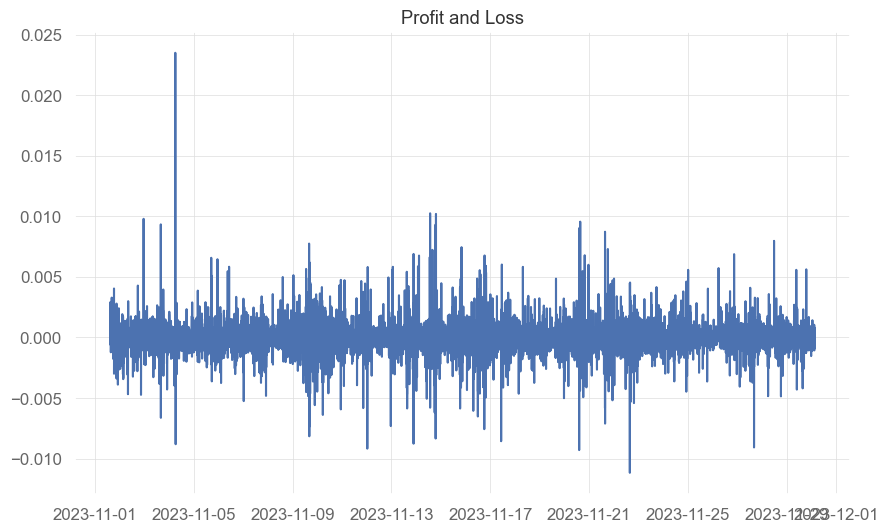

In [19]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-11-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             99.0%

Cumulative Return          5.35%
CAGR﹪                     59.87%

Sharpe                     0.03
Prob. Sharpe Ratio         67.05%
Smart Sharpe               0.03
Sortino                    0.05
Smart Sortino              0.04
Sortino/√2                 0.04
Smart Sortino/√2           0.03
Omega                      1.01

Max Drawdown               -3.36%
Longest DD Days            9
Volatility (ann.)          1.1%
Calmar                     17.82
Skew                       1.17
Kurtosis                   61.23

Expected Daily %           0.0%
Expected Monthly %         5.35%
Expected Yearly %          5.35%
Kelly Criterion            0.4%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.11%
Expected Shortfall (cVaR)  -0.11%

Max Consecutive Wins       11
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-21,2023-11-24,2023-11-30,9,-3.359275,-3.081134
2,2023-11-04,2023-11-04,2023-11-08,5,-2.680950,-2.397849
3,2023-11-14,2023-11-16,2023-11-17,3,-2.584484,-2.252978
4,2023-11-11,2023-11-12,2023-11-14,4,-2.579250,-2.410433
5,2023-11-14,2023-11-14,2023-11-14,1,-2.043781,-1.747972


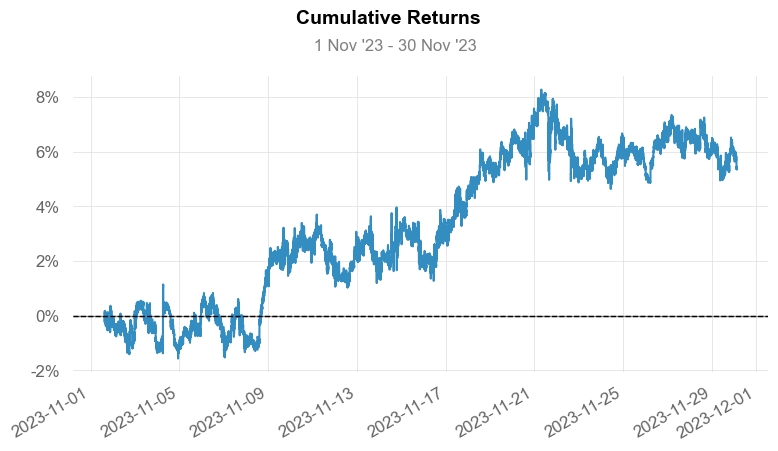

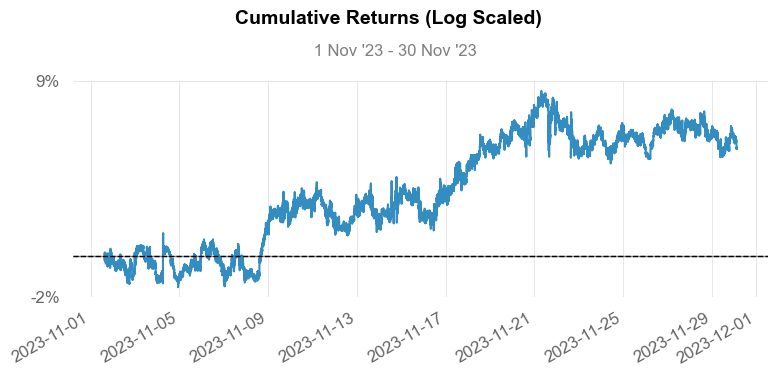

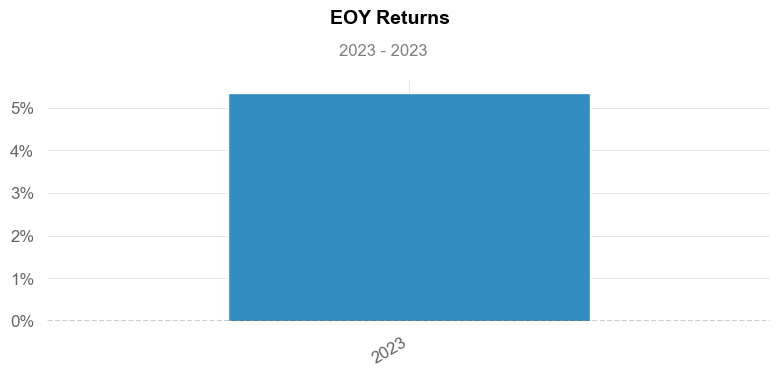

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


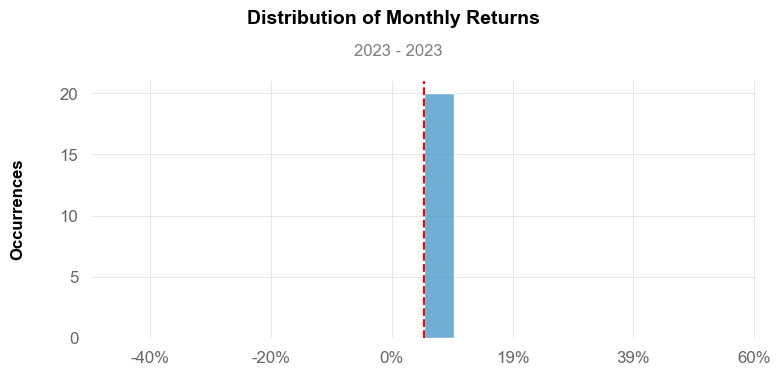

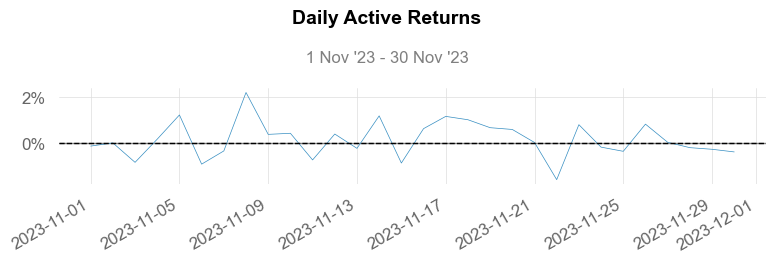

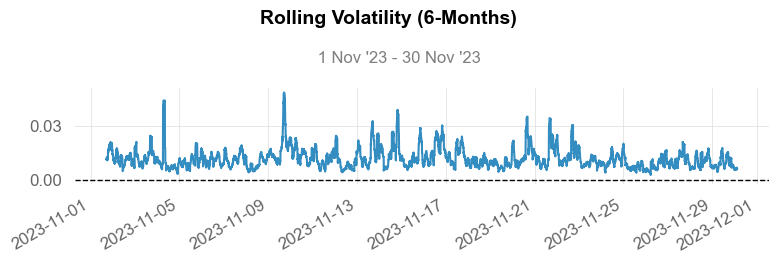

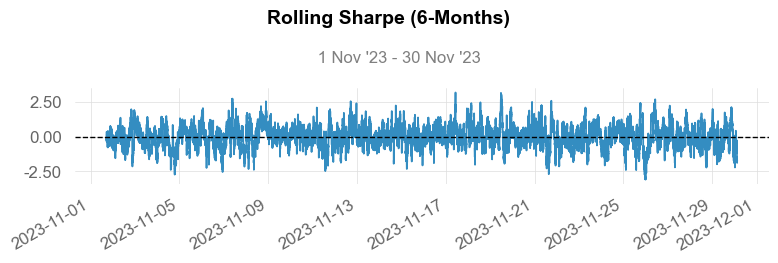

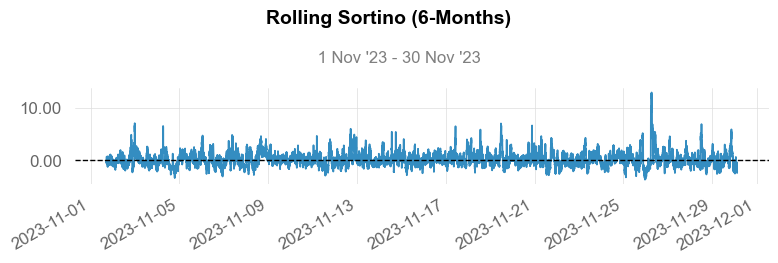

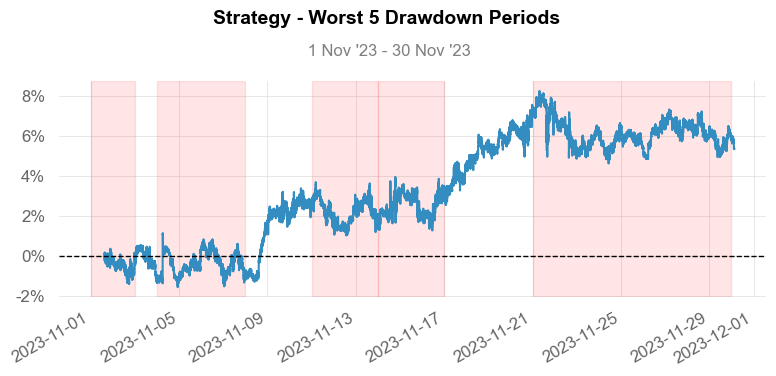

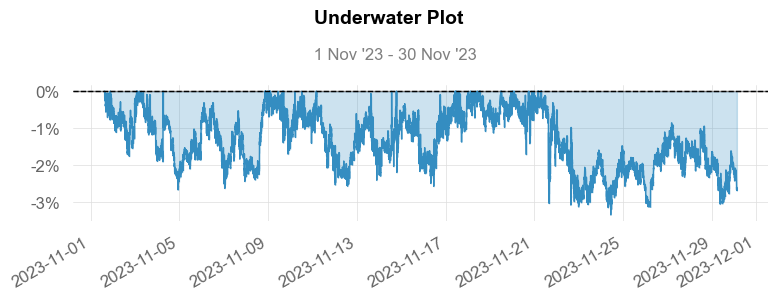

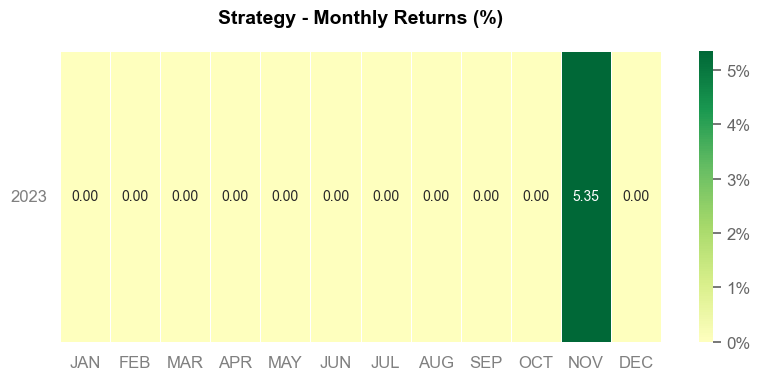

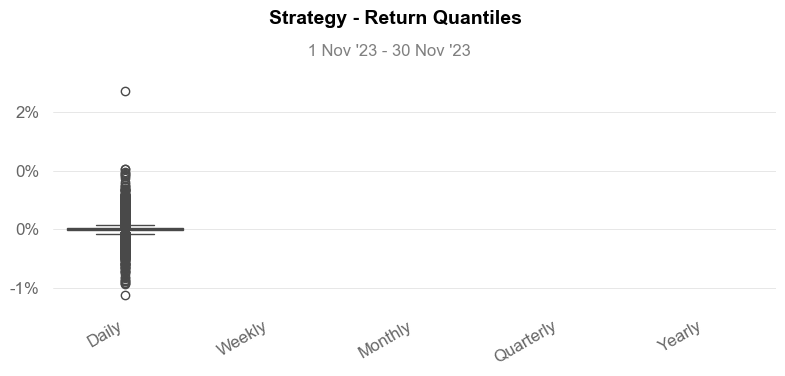

In [20]:
qs.reports.full(best_return['returns'])